In [90]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn import datasets
import numpy as np

In [91]:
df = pd.read_csv('car data(1.20).csv')

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [93]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [94]:
cat_col = df.select_dtypes(include='object').columns
num_col = df.select_dtypes(exclude='object').columns

In [95]:
num_col

Index(['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner'], dtype='object')

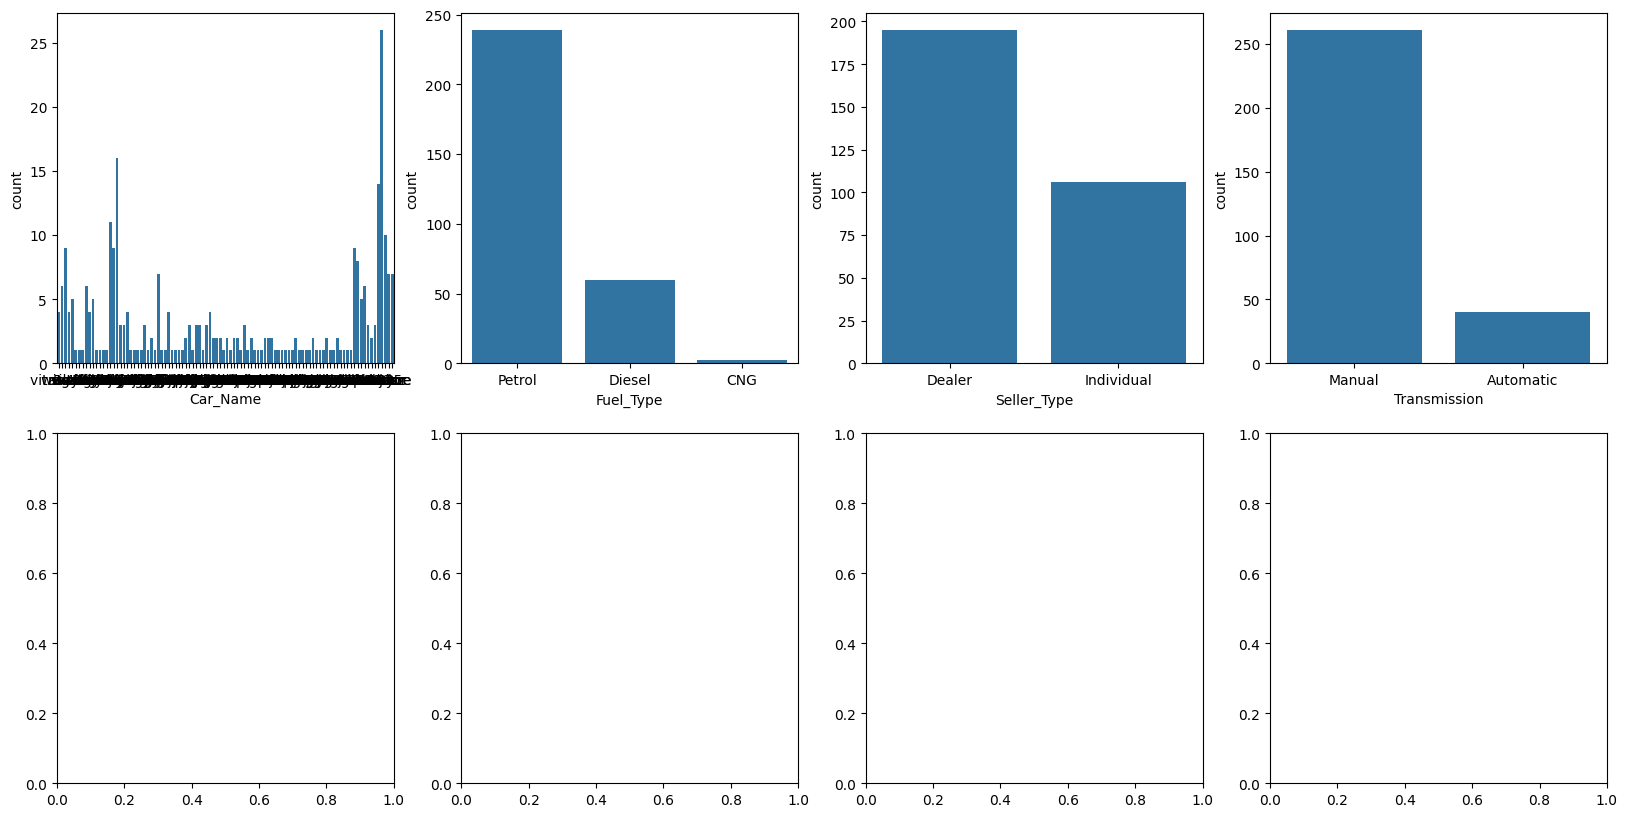

In [96]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# 범주형 확인
for i, var in enumerate(cat_col):
    row = i // 4
    col = i % 4
    sns.countplot(data=df, x=var, ax=axes[row, col])

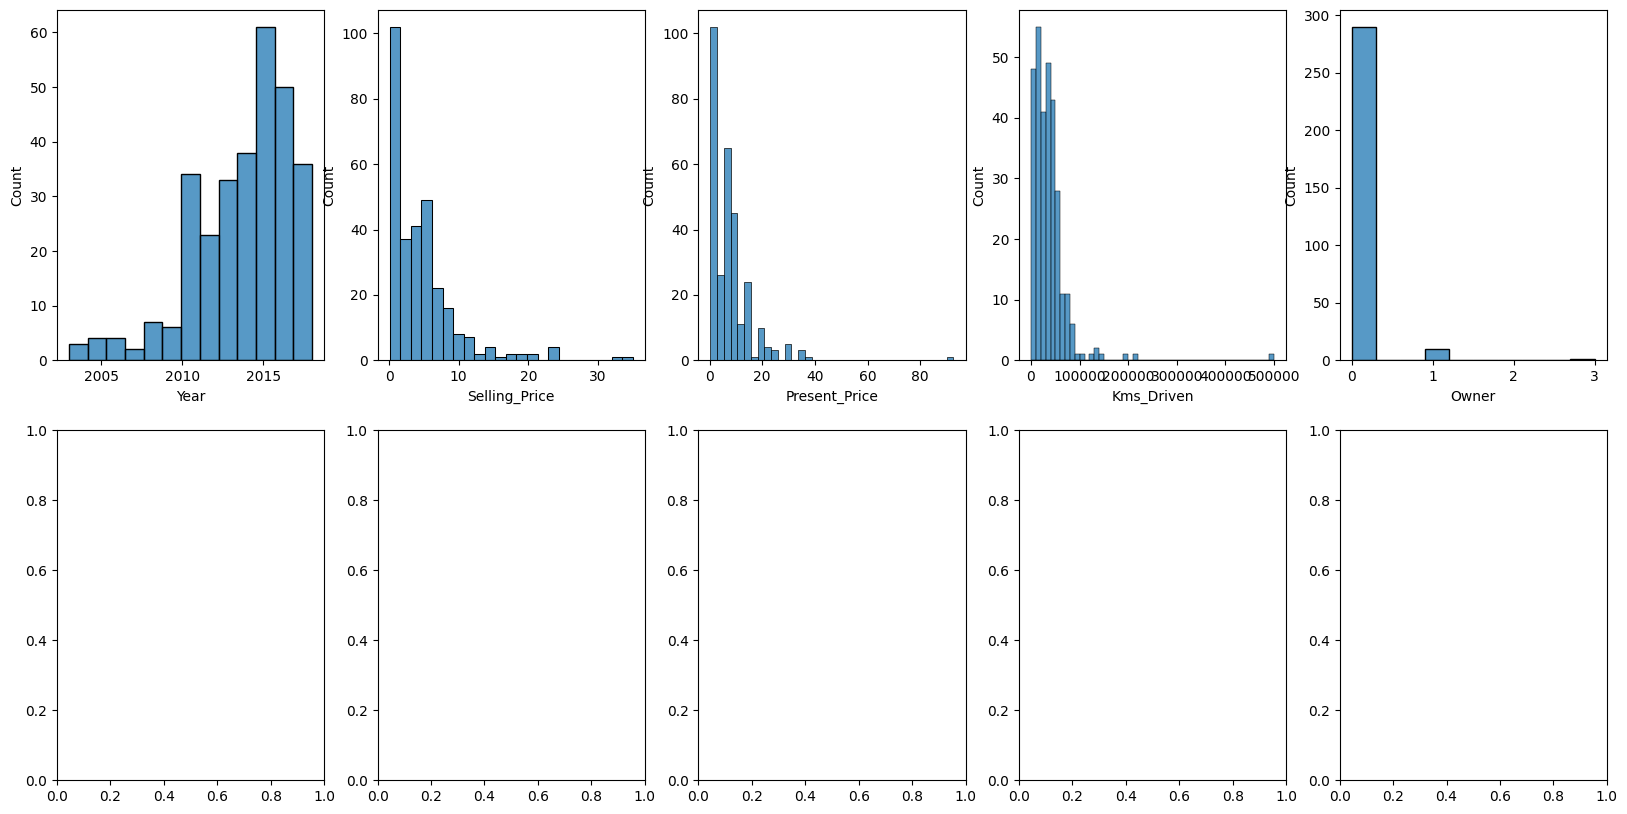

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# 수치형 확인
for i, var in enumerate(num_col):
    row = i // 5
    col = i % 5
    sns.histplot(data=df, x=var, ax=axes[row, col])

In [98]:
num_col

Index(['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner'], dtype='object')

In [99]:
# 이상치 확인
Q1 = df['Selling_Price'].quantile(0.25)
Q3 = df['Selling_Price'].quantile(0.75)
IQR = Q3-Q1
outline1 = df['Selling_Price']<Q1-1.5*IQR
outline2 = df['Selling_Price']>Q3+1.5*IQR
#  이상치 제거
df = df[~(outline1 | outline2)]
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [100]:
df = pd.get_dummies(df)

In [101]:
X = df.drop(['Selling_Price'], axis=1, inplace=False)
y = df[['Selling_Price']]
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=111)
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((227, 108), (57, 108), (227, 1), (57, 1))

In [102]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DF 변환
def get_linear_reg_eval(model_name, params = None, X_data_n =None, y_target_n=None,
                       verbose= True, return_coeff=True):
    coeff_df =pd.DataFrame()
    if verbose : print('######', model_name,'#######')
    for param in params:
        if model_name =='Ridge' : model = Ridge(alpha=param)
        elif model_name =='Lasso' : model = Lasso(alpha=param)
        elif model_name =='ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                        y_target_n, scoring= 'neg_mean_squared_error',cv= 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0} 일 때 5 폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        #cross_val_score 는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            #alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼 추가
            coeff = pd.Series(data=model.coef_, index =X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
    return coeff_df



In [103]:
# 라쏘에 사용될 alpha 파라미터 값 정의
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params= lasso_alphas, X_data_n =X_train, y_target_n= y_train)

###### Lasso #######
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.377
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.443
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 1.527
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.602
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 1.967


In [104]:
#엘라스틱넷에 사용될 alpha 파라미터 값 정의하고 함수 도출
# l1_ratio는 0.7로 고정 

elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet',params = elastic_alphas,
                                      X_data_n = X_train, y_target_n = y_train)

###### ElasticNet #######
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.340
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.380
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 1.516
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.562
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 1.891


In [105]:
#표준 정규 분포 변환( Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method =='Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method =='MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method =='Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
        
    if p_degree !=None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias =False).fit_transform(scaled_data)
    
    return scaled_data


In [106]:
#Ridge
alphas = [0.1, 1, 10, 100]
scale_methods =[(None, None),('Standard',None),('Standard',2),
               ('MinMax',None),('MinMax',2)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data =X_train)
    
    print('\n## 변환 유형 :{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params= alphas, X_data_n = X_data_scaled,
                       y_target_n = y_train, verbose=False, return_coeff =False)


## 변환 유형 :None, Polynomial Degree:None
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.267
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.188
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 1.255
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 1.390

## 변환 유형 :Standard, Polynomial Degree:None
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.539
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.482
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 1.310
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 1.378

## 변환 유형 :Standard, Polynomial Degree:2
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 4.833
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 3.157
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 2.471
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 2.301

## 변환 유형 :MinMax, Polynomial Degree:None
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.232
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.156
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 1.535
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 2.178

## 변환 유형 :MinMax, Polynomial Degree:2
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 0.792
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 0.850
alpha 10 일 때 5 폴드 세트의 평균 RMSE : 1.130
alpha 100 일 때 5 폴드 세트의 평균 RMSE : 1.693


In [108]:
# Rasso
alphas = [0.1, 1, 10, 100]
scale_methods =[(None, None),('Standard',None),('Standard',2),
               ('MinMax',None),('MinMax',2)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data =X_train)
    
    print('\n## 변환 유형 :{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Lasso', params= lasso_alphas, X_data_n = X_data_scaled,
                       y_target_n = y_train, verbose=False, return_coeff =False)


## 변환 유형 :None, Polynomial Degree:None
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.377
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.443
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 1.527
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.602
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 1.967

## 변환 유형 :Standard, Polynomial Degree:None
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.129
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.168
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 1.552
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 2.028
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 3.105

## 변환 유형 :Standard, Polynomial Degree:2
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.329
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.458
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 2.304
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 2.507
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 3.065

## 변환 유형 :MinMax, Polynomial Degree:None
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.412
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.534
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 2.311
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 2.929
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 3.105

## 변환 유형 :MinMax, Polynomial Degree:2
alpha 0.07 일 때 5 폴드 세트의 평균

In [109]:
# ElasticNet
alphas = [0.1, 1, 10, 100]
scale_methods =[(None, None),('Standard',None),('Standard',2),
               ('MinMax',None),('MinMax',2)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data =X_train)
    
    print('\n## 변환 유형 :{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('ElasticNet', params= elastic_alphas, X_data_n = X_data_scaled,
                       y_target_n = y_train, verbose=False, return_coeff =False)


## 변환 유형 :None, Polynomial Degree:None
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.340
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.380
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 1.516
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.562
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 1.891

## 변환 유형 :Standard, Polynomial Degree:None
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.114
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.135
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 1.505
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 1.881
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 2.933

## 변환 유형 :Standard, Polynomial Degree:2
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.684
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.731
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 2.200
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 2.439
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 2.918

## 변환 유형 :MinMax, Polynomial Degree:None
alpha 0.07 일 때 5 폴드 세트의 평균 RMSE : 1.546
alpha 0.1 일 때 5 폴드 세트의 평균 RMSE : 1.654
alpha 0.5 일 때 5 폴드 세트의 평균 RMSE : 2.332
alpha 1 일 때 5 폴드 세트의 평균 RMSE : 2.733
alpha 3 일 때 5 폴드 세트의 평균 RMSE : 3.105

## 변환 유형 :MinMax, Polynomial Degree:2
alpha 0.07 일 때 5 폴드 세트의 평균